# KNN Regressor using Wi-Fi Experiments

<p>Jupyter Notebook which aims to explore the ML algorithm K-Nearest Neighbors as a Regression algorithm using the Wi-Fi technology moreover using the strength of the signal as a basis. </p>

## Imports
Imports of the libraries to be used throughout the experiments

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

## Load File and Structure Data Function
Function to load csv and structure data accordingly

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

## Initialize Training Data

In [3]:
dataset = load_file('wifi_samples.csv')
X_train = dataset.iloc[:,9:]
Y_train = dataset.iloc[:,4:6]

## Radio Map Graphical Display

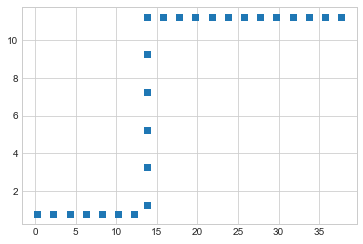

In [4]:
x , y = map(list, zip(*Y_train.values)) 
fig = plt.figure()
ax = plt.axes()
plt.plot(x,y,'s')

## Access Points Graphical Display
Graphical display with the average strength signal transmitted by each access point

<BarContainer object of 39 artists>

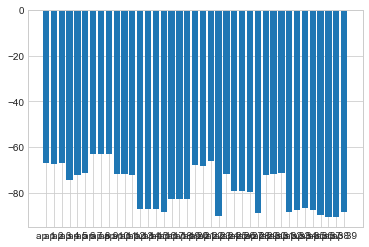

In [5]:
count_aps = {}
counter = 1
for ap in X_train:
    mean_value = dataset[ap].mean()
    count_aps['ap ' + str(counter)] = mean_value
    counter = counter + 1
plt.bar(range(len(count_aps)),list(count_aps.values()),align='center',tick_label=list(count_aps.keys()))

## Number of Fingerprints per Reference Point Graphical Display
Graphical display of the number of fingerprints retrieved at each reference point

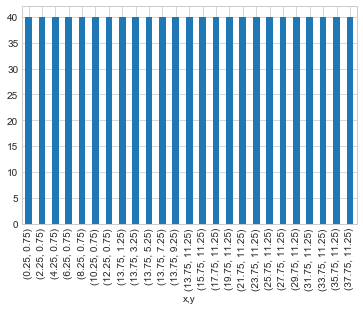

In [6]:
reference_points = dataset.groupby(['x','y'])
reference_points.size().plot(kind="bar")

## Signal Strength Distribution Display
Graphical display of the distribution of the signal strength

D:\Programs\Anaconda\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Programs\Anaconda\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Probability')

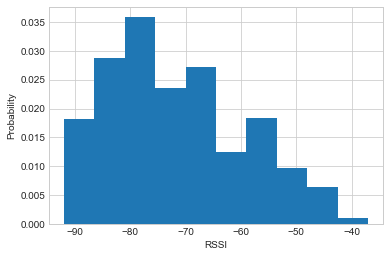

In [7]:
flatten_results = X_train.values.flatten().tolist()
flatten_results = list(filter((0).__ne__,flatten_results))
plt.hist(flatten_results,density=True)
plt.xlabel('RSSI')
plt.ylabel('Probability')

## Initialize KNN Parameters arrays
Initialization of the arrays with the different possible values for the parameters of KNN Regression function

In [8]:
#Knn Configurable parameters arary
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis","minkowski"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
filters = ["Median","Mean","No Filter"]
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler()]
weights = ["uniform","distance"]
default_data_scenario = Y_train.copy()
default_data_scenario_groups = default_data_scenario["x"].map(str)+","+default_data_scenario["y"].map(str)
nan_filler = X_train.min().min()*1.010
print(nan_filler)
X_train = X_train.fillna(nan_filler)
#Test data from separate csv file
test_dataset_from_file = load_file('testdata.csv')
X_test_from_file = test_dataset_from_file.iloc[:,3:]
Y_test_from_file = test_dataset_from_file.iloc[:,1:3]

-92.92


## Statistics Output Format
Structure of the statistical output of each call to the KNN Regression Function

In [9]:
def structure_data(data,rsquared):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    r_squared = rsquared
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue,r_squared]
    return statistical_results

## Configurable KNN Regression Function 
Configurable function to aplpy the knn to a training set

In [10]:
def compute_KNN_with_Regression(trainX_data = None,trainY_data = None,testX_data = None,testY_data = None,scaler = None,cross_validation = None,n_neighbors=5,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=-1):
    # Init the KNN Regressor Estimator
    knn_regression_estimator = KNeighborsRegressor(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_regression_estimator)
    else:
        main_estimator = knn_regression_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the training features
        predict_train = main_estimator.predict(trainX_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation,groups=default_data_scenario_groups)
        coefficient_determination = sklearn.metrics.r2_score(testY_data,predict_test)
    # Structure data to statistics
    statistical_array = list()
    coord_cols = ['x','y']
    predictions = pd.DataFrame(predict_test,columns=coord_cols)
    result = testY_data.join(predictions, rsuffix="_predicted")
    observed_errors = predictions[coord_cols] - result[coord_cols]
    error = pd.DataFrame(observed_errors.apply(np.linalg.norm, axis=1), columns=["error"])
    result = pd.concat([result,error], axis = 1)
    return structure_data(result,coefficient_determination)

## Experiments

### 1st Experiment - Running KNN function with default parameters and testing data equal to training data

In [11]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_KNN_with_Regression(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.305181,0.54954,0.74131,0.675915,0.0,0.0,0.0,1.6,0.0,4.8,0.996586


### 2nd Experiment - Running KNN function with default parameters and testing data from separate file

In [12]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
#result = compute_KNN_with_Regression(trainX_data=X_train,trainY_data=Y_train,testX_data=X_test_from_file,testY_data=Y_test_from_file,scaler=StandardScaler())
statistical_results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=statistical_results)
display(statistics)

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.305181,0.54954,0.74131,0.675915,0.0,0.0,0.0,1.6,0.0,4.8,0.996586


### 3rd Experiment - Finding the best k parameter with Grid Search

In [13]:
def grid_search():
    knn_regressor_estimator = KNeighborsRegressor() #init knn regressor estimator
    param_grid = {'knn__n_neighbors': np.arange(1, 31)}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_regressor_estimator)])
    estimator = GridSearchCV(pipe, param_grid,scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))
    #fit model to data
    print(X_train.values)
    print(Y_train.values)
    estimator.fit(X_train.values, Y_train.values)
    print(estimator.best_params_)
    return estimator.best_params_['knn__n_neighbors']


In [14]:
best_knn = grid_search()

[[-71.   -71.   -71.   ... -92.92 -92.92 -92.92]
 [-58.   -58.   -58.   ... -92.92 -92.92 -92.92]
 [-61.   -61.   -61.   ... -92.92 -92.92 -92.92]
 ...
 [-55.   -55.   -55.   ... -92.92 -92.92 -92.92]
 [-55.   -54.   -55.   ... -92.92 -92.92 -92.92]
 [-56.   -54.   -55.   ... -92.92 -92.92 -92.92]]
[[0.25 0.75]
 [0.25 0.75]
 [0.25 0.75]
 ...
 [8.25 0.75]
 [8.25 0.75]
 [8.25 0.75]]
{'knn__n_neighbors': 6}


### 4th Experiment - Finding the best k parameter with cross validation function

In [15]:
def find_fit_k():
    # search for an optimal value of K for KNN

    # range of k we want to try
    k_range = range(1, 31)
    # empty list to store scores
    k_scores = []

    # 1. we will loop through reasonable values of k
    for k in k_range:
        # 2. run KNeighborsClassifier with k neighbours
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X_train.values, Y_train.values,scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))
        # 4. append mean of scores for k neighbors to k_scores list
        k_scores.append(scores.mean())
    print('Length of list', len(k_scores))
    print('Max of list', max(k_scores))
    plt.plot(k_range, k_scores)
    plt.xlabel('Value of K for KNN')
    plt.ylabel('Cross-validated accuracy')

Length of list 30
Max of list -2.1850505555555557


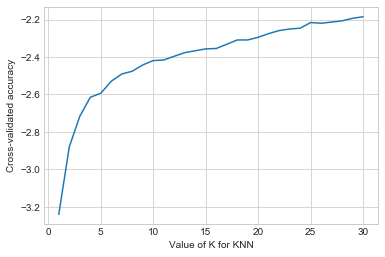

In [16]:
find_fit_k()

### 5th Experiment - Running the KNN function with default parameters and Hold-out Cross Validation

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,test_size
0,0.400000,0.748800,0.865332,0.771199,0.0,0.0,0.40000,2.02,0.0,3.6,0.993083,0.1
1,0.410828,0.736000,0.857904,0.755030,0.0,0.0,0.40000,2.00,0.0,4.0,0.994054,0.2
3,0.509000,1.038000,1.018823,0.883669,0.0,0.0,0.40000,2.40,0.0,7.2,0.993233,0.4
2,0.527219,1.099733,1.048682,0.908032,0.0,0.0,0.63598,2.40,0.0,7.2,0.992669,0.3
4,0.586232,1.181640,1.087033,0.916325,0.0,0.0,0.80000,2.40,0.0,7.2,0.992458,0.5


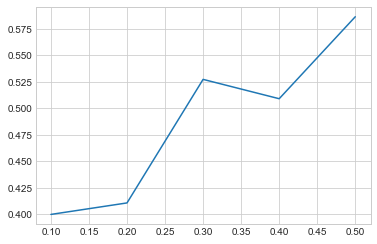

In [17]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
test_sizes = [0.1,0.2,0.3,0.4,0.5]
results = list()
for size in test_sizes:
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train,Y_train, test_size = size, random_state = 6,stratify=default_data_scenario_groups)
    X_train_split = X_train_split.reset_index(drop=True)
    X_test_split = X_test_split.reset_index(drop=True)
    y_train_split = y_train_split.reset_index(drop=True)
    y_test_split = y_test_split.reset_index(drop=True)
    result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    result.append(size)
    results.append(result)
statistical_cols.append('test_size')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['test_size'],statistics['mae'])

### 6th Experiment - Running the KNN function with default parameters and K-Fold cross validation

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
3,1.948767,6.06344,2.462405,1.505993,0.800000,2.0,2.4,4.800000,0.0,8.000000,0.954928,8
4,1.953585,6.01626,2.452807,1.483903,0.800000,2.0,2.4,4.400000,0.0,8.000000,0.956289,9
2,2.077899,6.81530,2.610613,1.581182,0.800000,2.0,2.8,5.200000,0.0,8.000000,0.947257,7
5,2.131936,6.59454,2.567984,1.432285,0.800000,2.0,2.8,4.400000,0.0,8.000000,0.947345,10
1,2.141180,8.83920,2.973079,2.063688,0.800000,2.0,2.8,5.375872,0.0,25.663983,0.937954,6
0,2.284328,8.61668,2.935418,1.844431,0.948683,2.0,2.8,6.000000,0.0,18.420098,0.932292,5


Number of Folds:  8


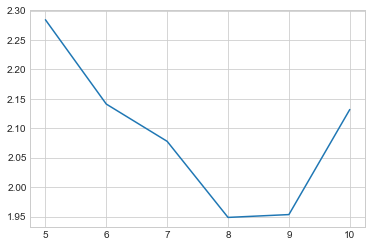

In [18]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(5,11)
results = list()
for cv in cross_validation_list:
    result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = cv)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Default Stratified KFold

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,folds
5,0.497747,1.12182,1.059160,0.935384,0.0,0.0,0.400000,2.4,0.0,6.800000,0.993205,10
4,0.509914,1.12014,1.058367,0.927895,0.0,0.0,0.400000,2.4,0.0,6.800000,0.993124,9
3,0.528631,1.16568,1.079667,0.941869,0.0,0.0,0.400000,2.4,0.0,6.800000,0.992905,8
2,0.533770,1.18760,1.089771,0.950575,0.0,0.0,0.400000,2.4,0.0,6.800000,0.992075,7
1,0.552379,1.17506,1.084002,0.933171,0.0,0.0,0.682719,2.4,0.0,6.800000,0.992737,6
0,0.606348,1.44138,1.200575,1.036724,0.0,0.0,0.800000,2.4,0.0,8.900562,0.988971,5


Number of Folds:  10


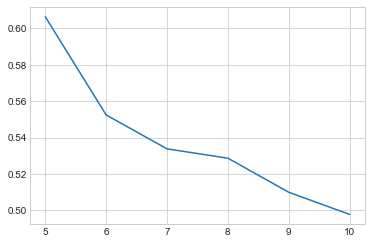

In [19]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
cross_validation_list = np.arange(5,11)
results = list()
for cv in cross_validation_list:
    skf = StratifiedKFold(n_splits=cv)
    splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
    result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
    result.append(cv)
    results.append(result)
statistical_cols.append('folds')
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['folds'],statistics['mae'])
selected_fold = statistics.sort_values(by=['mae'])['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

### Compare Stratified K-Fold strategies

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method
1,0.497747,1.12182,1.059160,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,Stratified K-Fold
0,2.131936,6.59454,2.567984,1.432285,0.8,2.0,2.8,4.4,0.0,8.0,0.947345,Cross Val Predict k-fold


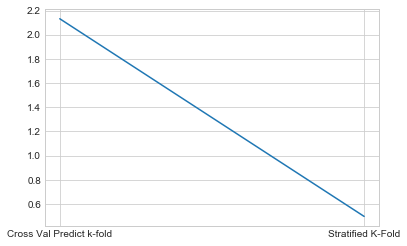

In [20]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method']
results = list()
kfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold)
kfold.append('Cross Val Predict k-fold')
results.append(kfold)
skf = StratifiedKFold(n_splits=selected_fold)
splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
skfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])

### 7th Experiment -  Running the KNN function with default parameters and Leave One Out cross validation

In [21]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
results = list()
cv = LeaveOneGroupOut()
splited = cv.split(X_train,Y_train,groups=default_data_scenario_groups)
loo = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)  
results.append(loo)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,2.351005,7.13024,2.670251,1.266736,1.6,2.0,2.8,4.42,0.0,8.8,0.946638


### Compare cross validation methods

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,method
3,0.497747,1.121820,1.059160,0.935384,0.0,0.000000,0.40000,2.400000,0.0,6.800000,0.993205,Stratified K-Fold
0,2.131936,6.594540,2.567984,1.432285,0.8,2.000000,2.80000,4.400000,0.0,8.000000,0.947345,Cross val Predict K-Fold
1,2.351005,7.130240,2.670251,1.266736,1.6,2.000000,2.80000,4.420000,0.0,8.800000,0.946638,LOO
2,13.389874,234.018511,15.297664,7.437625,8.0,13.462832,16.52318,24.561208,0.0,38.172503,0.992669,HoldOut


Selected cross validation method:  Stratified K-Fold


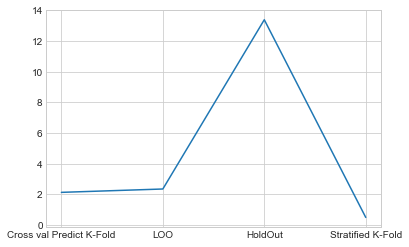

In [22]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','method']
results = list()
kfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold)
X_train_split, X_test_split, Y_train_split, Y_test_split = train_test_split(X_train,Y_train, test_size = 0.3, random_state = 6,stratify=Y_train)
X_train_split = X_train_split.reset_index(drop=True)
X_test_split = X_test_split.reset_index(drop=True)
y_train_split = y_train_split.reset_index(drop=True)
y_test_split = y_test_split.reset_index(drop=True)
holdout = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler())
kfold.append('Cross val Predict K-Fold')
results.append(kfold)
loo.append('LOO')
results.append(loo)
holdout.append('HoldOut')
results.append(holdout)
skf = StratifiedKFold(n_splits=selected_fold)
splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
skfold = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
skfold.append('Stratified K-Fold')
results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['method'],statistics['mae'])
selected_method = statistics.sort_values(by=['mae'])['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

### 9th Experiment - Running the KNN function with the different weights

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,weights
0,0.497747,1.12182,1.05916,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,uniform
1,0.497747,1.12182,1.05916,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,distance


Selected weight:  uniform


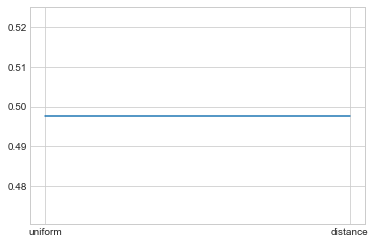

In [23]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','weights']
results = list()
for weight in weights:
    if selected_method == 'K-Fold':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                           weights = weight)
    elif selected_method == 'LOO':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                           weights = weight)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                           weights = weight)
    result.append(weight)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['weights'],statistics['mae'])
selected_weight = statistics.sort_values(by=['mae'])['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

### 10th Experiment - Running the KNN function with the different preprocessing methods

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,preprocessing
2,0.301892,0.67294,0.820329,0.763141,0.0,0.0,0.0,1.6,0.0,8.0,0.995405,MaxAbsScaler
1,0.388781,0.75974,0.871631,0.780512,0.0,0.0,0.4,2.0,0.0,6.0,0.994876,MinMaxScaler
0,0.497747,1.12182,1.059160,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,StandardScaler


Selected Preprocessing:  MaxAbsScaler


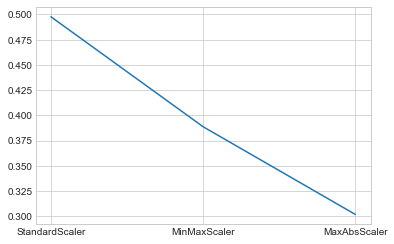

In [24]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','preprocessing']
results = list()
for preprocess in scaler:
    if selected_method == 'K-Fold':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = selected_fold)
    elif selected_method == 'LOO':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocess,cross_validation = splited)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocess)
    regex = re.search('(\w+)\(',str(preprocess)).group(1)
    result.append(regex)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['preprocessing'],statistics['mae'])
selected_preprocessing = statistics.sort_values(by=['mae'])['preprocessing'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

### 11th Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,algorithms
0,0.497747,1.12182,1.05916,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,brute
1,0.497747,1.12182,1.05916,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,kd_tree
2,0.497747,1.12182,1.05916,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,ball_tree
3,0.497747,1.12182,1.05916,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,auto


Selected Algorithm:  brute


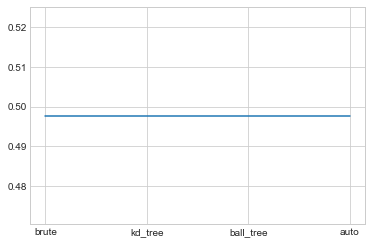

In [25]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','algorithms']
results = list()
for algorithm in algorithms:
    if selected_method == 'K-Fold':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            algorithm = algorithm)
    elif selected_method == 'LOO':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            algorithm = algorithm)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            algorithm = algorithm)
    result.append(algorithm)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['algorithms'],statistics['mae'])
selected_algorithm = statistics.sort_values(by=['mae'])['algorithms'].head(1).values[0]
print("Selected Algorithm: ",selected_algorithm)

### 12th Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance
1,0.288716,0.51162,0.715276,0.654745,0.0,0.0,0.0,1.6,0.0,6.0,0.996268,manhattan
3,0.303611,0.58106,0.762273,0.699550,0.0,0.0,0.0,1.6,0.0,6.0,0.995966,braycurtis
2,0.412671,0.85798,0.926272,0.829681,0.0,0.0,0.4,2.0,0.0,6.4,0.994698,canberra
0,0.497747,1.12182,1.059160,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,euclidean
4,0.497747,1.12182,1.059160,0.935384,0.0,0.0,0.4,2.4,0.0,6.8,0.993205,minkowski


Selected Distance Metric:  manhattan


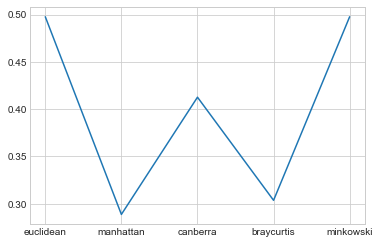

In [26]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance']
results = list()
for distance in distance_metris:
    if selected_method == 'K-Fold':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = selected_fold,
                                            metric = distance)
    elif selected_method == 'LOO':
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)  
    elif selected_method =='Stratified K-Fold':
        skf = StratifiedKFold(n_splits=selected_fold)
        splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
        result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),cross_validation = splited,
                                            metric = distance)
    else:
        result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=StandardScaler(),
                                            metric = distance)
    result.append(distance)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))
plt.plot(statistics['distance'],statistics['mae'])
selected_distance_metric = statistics.sort_values(by=['mae'])['distance'].head(1).values[0]
print("Selected Distance Metric: ",selected_distance_metric)

### 13th Experiment: Run with every configurable parameters and let the program decide the best parameters
Match these with the previously settled.

In [27]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','distance','preprocessing','weights']
results = list()
k_range = range(1, 31)
for distance in distance_metris:
    for preprocessing in scaler:
        for weight in weights:
            if selected_method == 'K-Fold':
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = selected_fold,
                                        metric = distance,weights=weight)
            elif selected_method == 'LOO':
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)  
            elif selected_method =='Stratified K-Fold':
                skf = StratifiedKFold(n_splits=selected_fold)
                splited = skf.split(X_train.values,default_data_scenario_groups,groups=default_data_scenario_groups)
                result = compute_KNN_with_Regression(testX_data=X_train,testY_data=Y_train,scaler=preprocessing,cross_validation = splited,
                                                    metric = distance,weights=weight)
            else:
                result = compute_KNN_with_Regression(trainX_data=X_train_split,trainY_data=Y_train_split,testX_data=X_test_split,testY_data=Y_test_split,scaler=preprocessing,
                                                    metric = distance,weights=weight)
            result.append(distance)
            regex = re.search('(\w+)\(',str(preprocessing)).group(1)
            result.append(regex)
            result.append(weight)
            results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,distance,preprocessing,weights
11,0.226001,0.505089,0.710696,0.674142,1.110223e-16,1.776357e-15,3.972055e-15,1.400126,0.0,8.000000,0.996425,manhattan,MaxAbsScaler,distance
23,0.228165,0.505725,0.711143,0.673884,1.110223e-16,1.776357e-15,3.972055e-15,1.442988,0.0,8.000000,0.996457,braycurtis,MaxAbsScaler,distance
21,0.231674,0.407408,0.638285,0.595054,1.110223e-16,1.779823e-15,3.972055e-15,1.219220,0.0,6.000000,0.996626,braycurtis,MinMaxScaler,distance
10,0.233364,0.517480,0.719361,0.680797,0.000000e+00,0.000000e+00,0.000000e+00,1.600000,0.0,8.000000,0.996322,manhattan,MaxAbsScaler,uniform
22,0.235764,0.518120,0.719806,0.680440,0.000000e+00,0.000000e+00,0.000000e+00,1.600000,0.0,8.000000,0.996355,braycurtis,MaxAbsScaler,uniform
9,0.239793,0.458910,0.677429,0.633886,1.110223e-16,1.776357e-15,3.972055e-15,1.281788,0.0,6.000000,0.996522,manhattan,MinMaxScaler,distance
20,0.241116,0.422500,0.650000,0.603927,0.000000e+00,0.000000e+00,0.000000e+00,1.200000,0.0,6.000000,0.996522,braycurtis,MinMaxScaler,uniform
17,0.244425,0.539367,0.734416,0.692895,1.110223e-16,1.776357e-15,3.972055e-15,1.553600,0.0,8.000000,0.996191,canberra,MaxAbsScaler,distance
8,0.249116,0.474980,0.689188,0.642911,0.000000e+00,0.000000e+00,0.000000e+00,1.600000,0.0,6.000000,0.996428,manhattan,MinMaxScaler,uniform
16,0.252578,0.552620,0.743384,0.699510,0.000000e+00,0.000000e+00,0.000000e+00,1.600000,0.0,8.000000,0.996082,canberra,MaxAbsScaler,uniform


### 14th Experiment: Running the KNN function with data filtered 

In [28]:
def apply_filter():
    statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared','filter']
    results = list()
    for filterelement in filters:
        if filterelement == 'Median':
            result = apply_median_filter()
        elif filterelement == 'Mean':
            result = apply_mean_filter()
        else:
            result = compute_KNN_with_Regression(trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
            result.append('No Filter')
        results.append(result)
    statistics = pd.DataFrame(columns=statistical_cols,data=results)
    display(statistics.sort_values(by=['mae']))
    plt.plot(statistics['filter'],statistics['mae'])
    selected_filter = statistics.sort_values(by=['mae'])['filter'].head(1).values[0]
    print("Selected Filter: ",selected_filter)
    return selected_filter
            

def apply_median_filter():
    medians = list()
    aps = ['x','y']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        x = rp[0]
        y = rp[1]
        medians_list = [x,y]
        for ap in X_train:
            median = access_points[ap].median()
            medians_list.append(median)
        medians.append(medians_list)
    median_pd = pd.DataFrame(medians,columns = aps)
    x_train = median_pd.iloc[:,2:]
    x_train = x_train.fillna(nan_filler)
    y_train = median_pd.iloc[:,:2]
    result = compute_KNN_with_Regression(trainX_data=x_train,trainY_data=y_train,testX_data=x_train,testY_data=y_train,scaler=StandardScaler(),metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Median')
    return result

def apply_mean_filter(): 
    means = list()
    aps = ['x','y']
    for col in X_train.columns: 
         aps.append(col)
    for rp, access_points in reference_points:
        x = rp[0]
        y = rp[1]
        means_list = [x,y]
        for ap in X_train:
            mean = access_points[ap].mean()
            means_list.append(mean)
        means.append(means_list)
    mean_pd = pd.DataFrame(means,columns = aps)
    x_train = mean_pd.iloc[:,2:]
    y_train = mean_pd.iloc[:,:2]
    nan_filler = x_train.min().min()*1.010
    x_train = x_train.fillna(nan_filler)
    result = compute_KNN_with_Regression(trainX_data=x_train,trainY_data=y_train,testX_data=x_train,testY_data=y_train,scaler=StandardScaler(),metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
    result.append('Mean')
    return result

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared,filter
2,0.158000,0.24048,0.490388,0.464469,0.0,0.0,0.0,0.8,0.0,4.8,0.998196,No Filter
0,1.648546,4.50640,2.122828,1.365000,0.0,2.0,2.0,4.0,0.0,4.8,0.960420,Median
1,1.730488,5.10480,2.259380,1.482611,0.0,2.0,2.0,4.0,0.0,4.8,0.952972,Mean


Selected Filter:  No Filter


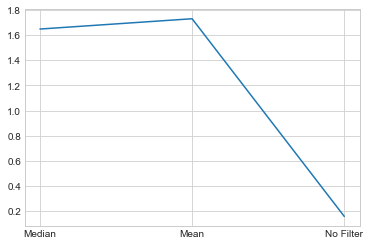

In [29]:
selected_filter = apply_filter()

## Results Analysis and Conclusion
Analysis of the outcomes of the different experiments and final conclusions.

In [30]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance','Filtering']
conclusion_list = [best_knn,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance_metric,selected_filter]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance,Filtering
0,6,Stratified K-Fold,uniform,MaxAbsScaler,brute,manhattan,No Filter


#### Best Result

In [31]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','r-squared']
result = compute_KNN_with_Regression(n_neighbors=best_knn,trainX_data=X_train,trainY_data=Y_train,testX_data=X_train,testY_data=Y_train,scaler=StandardScaler(),metric = selected_distance_metric,algorithm=selected_algorithm,weights=selected_weight)
results = [result]
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['mae']))

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,r-squared
0,0.185,0.275667,0.52504,0.491613,0.0,0.0,0.0,1.0,0.0,5.0,0.997922
